# TriageAssist

In [36]:
import pandas as pd

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

## Load data

In [40]:
# data cleaning
df = pd.read_csv('heart.csv', header = 0)

In [49]:
# data cleaning
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

### 1 = male, 0 = female
print(df.isnull().sum())

df['Sex'] = df.Sex.map({0: 'female', 1: 'male'})

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [48]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,NaN,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,NaN,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,NaN,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,NaN,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,NaN,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [46]:
################################## data preprocessing
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [47]:
from sklearn.preprocessing import StandardScaler as ss
sc = ss()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

ValueError: could not convert string to float: 'ASY'

### Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

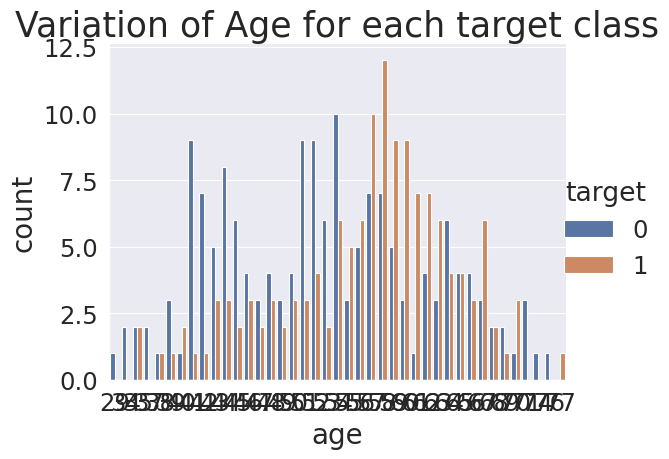

In [ ]:
# distribution of target vs age 
from matplotlib import rcParams

# set figure size
rcParams['figure.figsize'] = 20, 12

sns.set(rc={'figure.figsize':(50, 12)})
sns.set_context("paper", font_scale = 2, rc = {"font.size": 20,"axes.titlesize": 25,"axes.labelsize": 20}) 
sns.catplot(kind = 'count', data = df, x = 'age', hue = 'target', order = df['age'].sort_values().unique())
plt.title('Variation of Age for each target class')
plt.tight_layout()
plt.show()

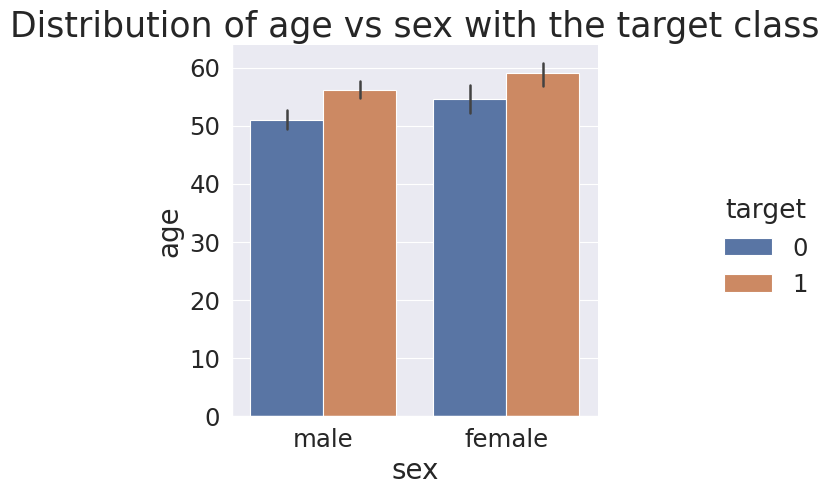

In [ ]:
# barplot of age vs sex with hue = target
sns.catplot(kind = 'bar', data = df, y = 'age', x = 'sex', hue = 'target')
plt.title('Distribution of age vs sex with the target class')
plt.show()

df['sex'] = df.sex.map({'female': 0, 'male': 1})

In [ ]:
print(X_train)

[[44.  1.  4. ...  1.  1.  3.]
 [55.  1.  4. ...  2.  1.  7.]
 [54.  1.  4. ...  2.  1.  7.]
 ...
 [35.  0.  4. ...  1.  0.  3.]
 [50.  1.  4. ...  2.  0.  7.]
 [59.  0.  4. ...  2.  0.  3.]]


## FairLearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

In [ ]:
# data cleaning
df = pd.read_csv('cleveland.csv', header = None)

df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang', 
              'oldpeak', 'slope', 'ca', 'thal', 'target']

In [ ]:
print(len(df.index))

303


In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### Dataset Imbalances

In [ ]:
dataset = df

df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
df['sex'] = df.sex.map({0: 'female', 1: 'male'})
df['thal'] = df.thal.fillna(df.thal.mean())
df['ca'] = df.ca.fillna(df.ca.mean())

In [ ]:
categorical_features = ["sex"]

for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

Y, A = dataset.loc[:, "target"], dataset.loc[:, "sex"]
X = pd.get_dummies(dataset.drop(columns=["target", "sex"]))

In [ ]:
# gender
A.value_counts(normalize=True)

sex
male      0.679868
female    0.320132
Name: proportion, dtype: float64

In [ ]:
Y.value_counts(normalize=True)

target
0    0.541254
1    0.458746
Name: proportion, dtype: float64